(sec:dispersion)=
# Dispersion interactions

## Long-range interaction energy

The interaction energy between two molecular systems $A$ and $B$ is given by

$$
\Delta E = E_\mathrm{AB} - E_\mathrm{A} - E_\mathrm{B}
$$

For charge neutral, nonpolar, systems separated by a large distance $R$ this interaction energy is known as dispersion (or van der Waals) energy.

## Dispersion and correlation



The prototypical system exemplifying dispersion interactions is the  He dimer for which the interaction energy equals

$$
\Delta E(R) = E_\mathrm{dimer} - 2E_\mathrm{He}
$$

We will determine this interaction energy with respect to the interatomic separation distance at the Hartree–Fock and MP2 levels of theory.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import veloxchem as vlx

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [2]:
au2ang = 0.529177

In [3]:
atom_xyz = """1
He atom                                                                                                                
He    0.000000000000        0.000000000000        0.000000000000 
"""

dimer_xyz = """2
He dimer                                                                                                                          
He    0.000000000000        0.000000000000        0.000000000000                         
He    0.000000000000        0.000000000000        dimer_separation
"""

In [4]:
atom = vlx.Molecule.from_xyz_string(atom_xyz)
atom_basis = vlx.MolecularBasis.read(atom, "aug-cc-pvtz")

dimer = vlx.Molecule.from_xyz_string(dimer_xyz.replace("dimer_separation", "5.0"))
dimer_basis = vlx.MolecularBasis.read(dimer, "aug-cc-pvtz")

* Info * Reading basis set from file: /opt/miniconda3/envs/vlxenv/lib/python3.9/site-packages/veloxchem/basis/AUG-CC-PVTZ 
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: AUG-CC-PVTZ                                                                      
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                                                                                                          
                

Determine the atomic energies the HF and MP2 levels of theory.

In [5]:
scf_drv = vlx.ScfRestrictedDriver()
mp2_drv = vlx.mp2driver.Mp2Driver()

scf_results = scf_drv.compute(atom, atom_basis)
hf_atom_energy = scf_drv.get_scf_energy()

mp2_results = mp2_drv.compute(atom, atom_basis, scf_drv.mol_orbs)
mp2_atom_energy = hf_atom_energy + mp2_results['mp2_energy']

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

Determine the dimer energies over a range of interatomic separation distance.

In [6]:
distances = np.linspace(2.75, 5.0, 10)

hf_dimer_energies = []
mp2_dimer_energies = []

for dist in distances:

    dimer = vlx.Molecule.from_xyz_string(
        dimer_xyz.replace("dimer_separation", str(dist))
    )

    scf_results = scf_drv.compute(dimer, dimer_basis)
    hf_dimer_energies.append(scf_drv.get_scf_energy())

    mp2_results = mp2_drv.compute(dimer, dimer_basis, scf_drv.mol_orbs)
    mp2_dimer_energies.append(scf_drv.get_scf_energy() + mp2_results['mp2_energy'])

hf_dimer_energies = np.array(hf_dimer_energies)
mp2_dimer_energies = np.array(mp2_dimer_energies)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

Plot the interaction energies.

In [7]:
hf_interaction_energies = hf_dimer_energies - 2 * hf_atom_energy

mp2_interaction_energies = mp2_dimer_energies - 2 * mp2_atom_energy

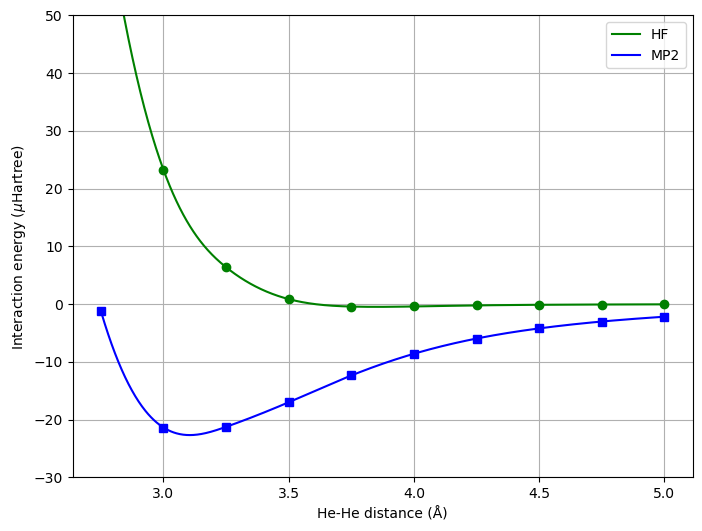

In [8]:
R = np.linspace(2.75, 5.0, 1000)

plt.figure(figsize=(8, 6))

x, y = distances, hf_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "g-", label="HF")
plt.plot(x, y, "go")

x, y = distances, mp2_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "b-", label="MP2")
plt.plot(x, y, "bs")

plt.xlabel("He-He distance (Å)")
plt.ylabel(r"Interaction energy ($\mu$Hartree)")

plt.ylim(-30, 50)

plt.legend()
plt.grid(True)

plt.show()

The failure of the HF method to describe the minimum of the potential energy curve for the helium dimer is due to the lack of correlation. 

More specifically, let us consider a system setup where the $z$-axis is chosen as the internuclear axis and the helium atoms are placed at $z = 0$ and $z=R_0$, respectively (see the inset in the figure below). We will then be concerned with the [two-particle density](reduced_densities), $n(\mathbf{r}_1, \mathbf{r}_2)$, at coordinates

\begin{align*}
\mathbf{r}_1 & = d (1, 0,0) \\
\mathbf{r}_2 & = d (\cos\theta, \sin\theta,R_0) \\
\end{align*}

At the HF level of theory, the two-particle density will be independent of the angle $\theta$ whereas this is not the case when electron correlation is accounted for. The MP2 density shows a maximum when the two electrons are positioned as far apart as possible, or in other words as $\theta = 180^\circ$. 

![Two-particle density He dimer](../../img/misc/he_dimer.svg)

This asymmetry in the two-particle density is referred to as fluctuating induced dipoles, or instantaneous dipole–dipole interactions, and it is the source origin of the weakly attractive van der Waals energies.

## Dispersion by perturbation theory

The long-range interaction energy between two randomly oriented molecules $A$ and $B$ is given by the Casimir–Polder potential

\begin{eqnarray*}
  \Delta E(R) & = & - \frac{\hbar}{\pi R^6} \int_{0}^{\infty} 
  \overline{\alpha}_A(i\omega^I)
  \overline{\alpha}_B(i\omega^I)
  e^{-2\omega^I R/c} 
  \\ \nonumber && \times
\left[
    3 + 6 \frac{\omega^I R}{c} 
    + 5 \left(\frac{\omega^I R}{c}\right)^2
    + 2 \left(\frac{\omega^I R}{c}\right)^3
    + \left(\frac{\omega^I R}{c}\right)^4
\right]
d\omega^I
\end{eqnarray*}

where $R$ is the intermolecular separation, $c$ is the speed of light, and $\overline{\alpha}_A(i\omega^I)$ is the isotropic average of the electric dipole polarizability tensor of molecule $A$ evaluated at a purely imaginary frequency. The molecules are here considered to be polarizable entities. Additional contributions to the energy will arise from higher-order electric multipole interactions as well as magnetic interactions. 

The interaction energy is often expressed in terms of dispersion coefficients $C_m$, where $m = 6, 8, 10, \ldots$, and long-range coefficients $K_n$, where $n = 7, 9, 11, \ldots$, so that, in the van der Waals region, we have

\begin{equation*}
  \Delta E(R) = -\frac{C_6}{R^6} -\frac{C_8}{R^8}
  -\frac{C_{10}}{R^{10}} - \cdots 
\end{equation*}

and, at very large intermolecular separation, we have 

\begin{equation*}
  \Delta E(R) = -\frac{K_7}{R^7} -\frac{K_9}{R^9}
  -\frac{K_{11}}{R^{11}} -  \cdots 
\end{equation*}

The reason for the deviation of the interaction energy at large $R$ from a $1/R^6$ dependence, as given by London–van der Waals dispersion theory, is the finite speed of the photons mediating the electromagnetic interaction, or, equivalently, retardation.

The leading dispersion coefficient is given by

\begin{equation*}
  C_6 =
  \frac{3\hbar}{\pi} \int_{0}^{\infty} 
  \overline{\alpha}_A(i\omega)
  \overline{\alpha}_B(i\omega) d\omega  
\end{equation*}

In [12]:
c6_drv = vlx.C6Driver()

scf_results = scf_drv.compute(atom, atom_basis)
c6_results = c6_drv.compute(atom, atom_basis, scf_results)

hf_c6 = c6_results['c6']

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

Based on Hartree–Fock data and with access to the $C_6$ dispersion coefficient, a much more realistic potential energy curve can be constructed as follows

$$
\Delta E(R) = \Delta E^\mathrm{HF}(R) -
\frac{C_6}{R^6}
$$

where the first and second term contribute the repulsive and attractive parts of the potential, respectively.

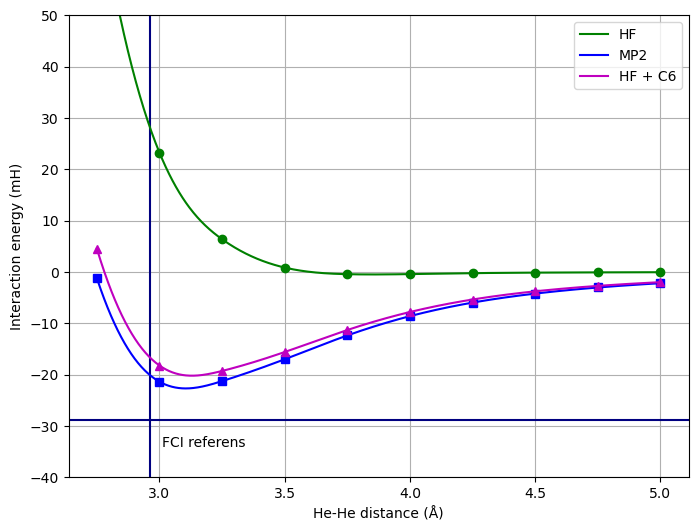

In [13]:
plt.figure(figsize=(8, 6))

# Reference data at FCI level
plt.axvline(5.6 * au2ang, color="navy")
plt.axhline(-28.76, color="navy")
plt.text(3.01, -34, "FCI referens")

x, y = distances, hf_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "g-", label="HF")
plt.plot(x, y, "go")

x, y = distances, mp2_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "b-", label="MP2")
plt.plot(x, y, "bs")

x, y = distances, (hf_interaction_energies - hf_c6 / (distances / au2ang) ** 6) * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "m-", label="HF + C6")
plt.plot(x, y, "m^")

plt.xlabel("He-He distance (Å)")
plt.ylabel("Interaction energy (mH)")

plt.ylim(-40, 50)

plt.legend()
plt.grid(True)

plt.show()

A FCI reference value for the binding energy, 29 $\mu$Hartree, and equilibrium distance, 2.96 Å, is depicted in the figure as the crossing point of the vertical and horizontal lines. Both the MP2 and the dispersion-corrected HF minima are quite close to this FCI reference point.

It has become a standard procedure to adopt a similar approach to add dispersion corrections to DFT potentials as standard functionals do not offer an inclusion of dispersion interactions. This can be very important when performing molecular structure optimizations of systems with nonbonded interactions.